In [1]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import tensorflow as tf
import collections
from networkenv import NetworkEnv
import game
from lib import plotting
import utils
import networkx as nx

In [84]:
# create some rules for the game
r = game.Rules()
r.nb_max_step = 20
r.nb_players = 5
# create a game with these rules
g = game.Game(r)
p1 = game.Player()
p1.name = "RL"
p1.rules = r
p1.type = game.EntityType.competitive_player
g.add_player(p1)

greedy_player = utils.create_greedy_player("Heuristic", r)
g.add_player(greedy_player)

# create an RL environment with with game
env = NetworkEnv(g, reward_func="centrality")

In [85]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.001, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [1, env.observation_space.shape], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            #state_one_hot = tf.one_hot(self.state, int(env.observation_space.shape))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()]) 
            self.loss = -tf.log(self.picked_action_prob) * self.target + 0.002 * self.l2_loss
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.001, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [1, env.observation_space.shape], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            # state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))


            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        if i_episode % 100 == 0:
            env.render()
        # Reset the environment and pick the first action
        state = env.reset()
            
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()

            if done:
                break
                
            state = next_state
        
        #if i_episode % 50 == 0:
         #   env.render()  
        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # The return after this timestep
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            # Update our value estimator
            estimator_value.update(transition.state, total_return)
            # Calculate baseline/advantage
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            # Update our policy estimator
            estimator_policy.update(transition.state, advantage, transition.action)
    
    return stats

tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

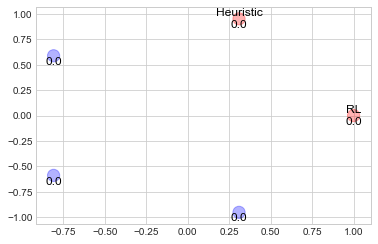

Step 19 @ Episode 100/2000 (6.166666666666667))

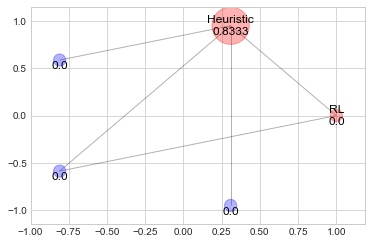

Step 19 @ Episode 200/2000 (2.833333333333333)6)

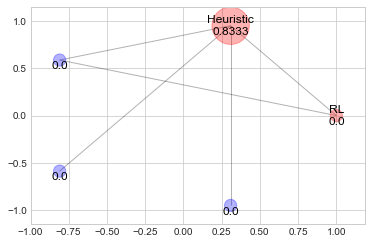

Step 19 @ Episode 300/2000 (2.7499999999999996))

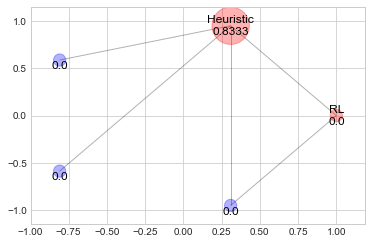

Step 19 @ Episode 400/2000 (1.6666666666666665))

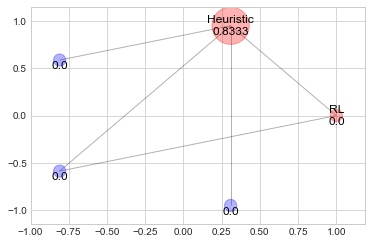

Step 19 @ Episode 500/2000 (9.333333333333332)6)

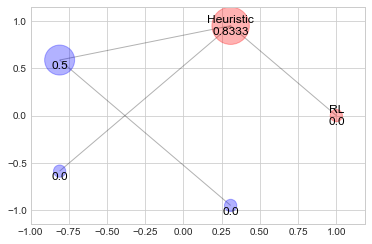

Step 19 @ Episode 600/2000 (3.7499999999999996))

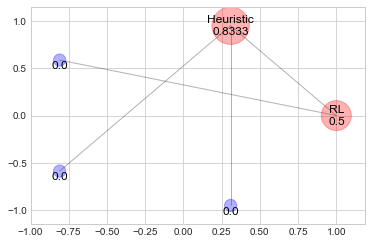

Step 19 @ Episode 700/2000 (8.5)3333333333332)))

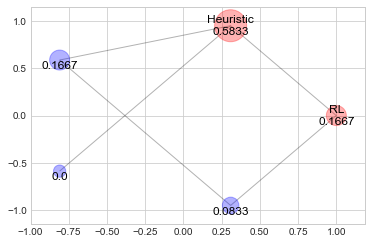

Step 19 @ Episode 800/2000 (0.0)3333333333332)))

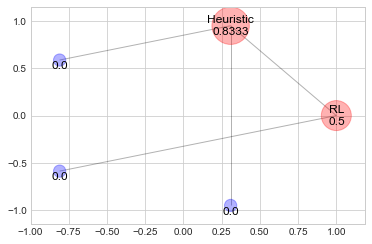

Step 19 @ Episode 900/2000 (9.999999999999998)))

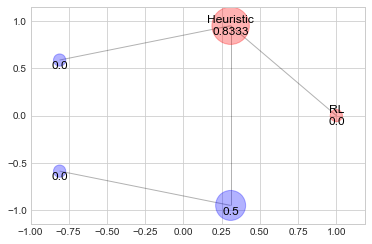

Step 19 @ Episode 1000/2000 (9.5)333333333332)))

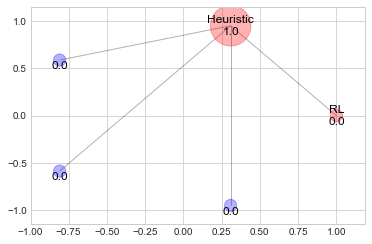

Step 19 @ Episode 1100/2000 (9.166666666666666)))

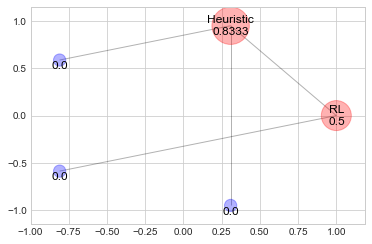

Step 19 @ Episode 1200/2000 (9.333333333333332)))

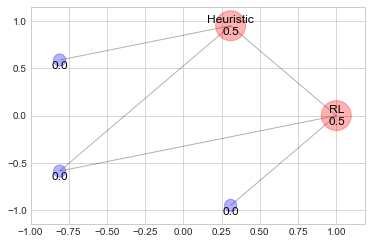

Step 19 @ Episode 1300/2000 (9.333333333333332)))

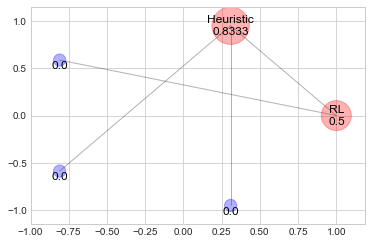

Step 19 @ Episode 1400/2000 (5.5)3333333333332)))

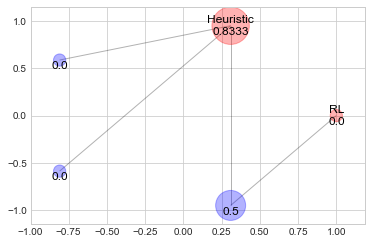

Step 19 @ Episode 1500/2000 (9.416666666666666)))

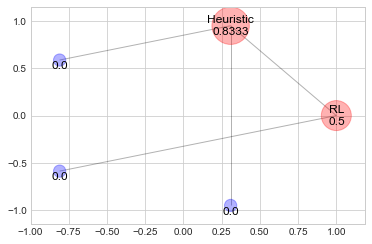

Step 19 @ Episode 1600/2000 (9.333333333333332)))

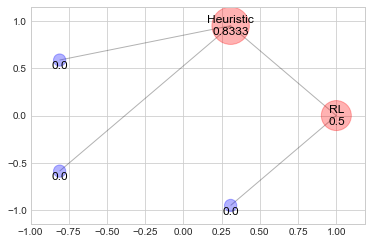

Step 19 @ Episode 1700/2000 (9.0)333333333333333)

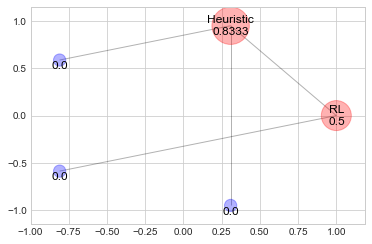

Step 19 @ Episode 1800/2000 (9.333333333333332)3)

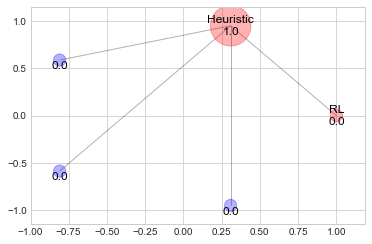

Step 19 @ Episode 1900/2000 (1.583333333333333)))

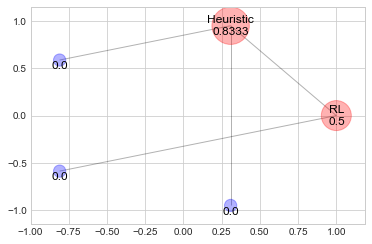

Step 19 @ Episode 2000/2000 (15.833333333333337))

In [86]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    stats = reinforce(env, policy_estimator,
                      value_estimator, 2000, discount_factor=.99)

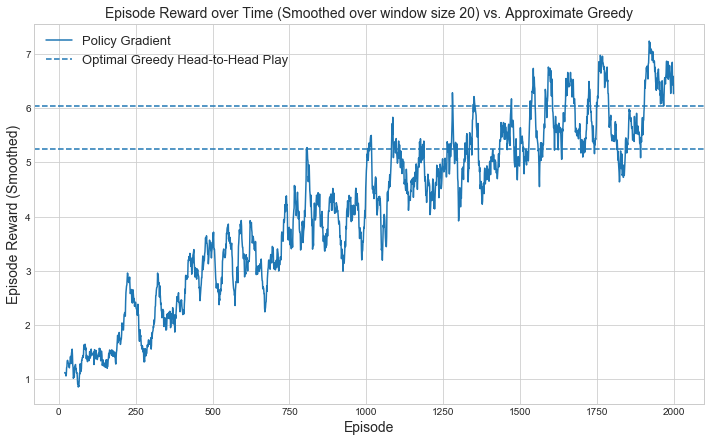

In [83]:
import pandas as pd
plt.style.use("seaborn-whitegrid")
smoothing_window = 20
fig, ax = plt.subplots(figsize=(12,7))
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
plt.plot(rewards_smoothed, label="Policy Gradient")
#plt.axhline(14.33, linestyle="--", label="Optimal Play")
# head-to-head greedy optimal
plt.axhline(5.249, linestyle="--", label="Optimal Greedy Head-to-Head Play")
plt.axhline(6.042, linestyle="--")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Episode Reward (Smoothed)", fontsize=14)
plt.title("Episode Reward over Time (Smoothed over window size {}) vs. Approximate Greedy".format(smoothing_window), fontsize=14)
plt.legend(fontsize=13)

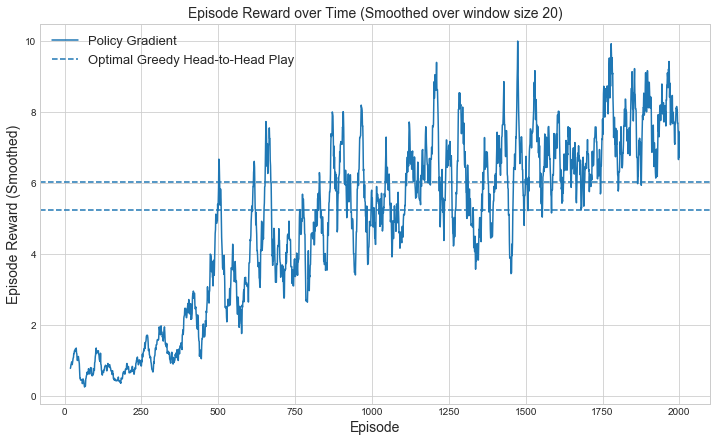

In [87]:
import pandas as pd
plt.style.use("seaborn-whitegrid")
smoothing_window = 20
fig, ax = plt.subplots(figsize=(12,7))
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
plt.plot(rewards_smoothed, label="Policy Gradient")
#plt.axhline(14.33, linestyle="--", label="Optimal Play")
# head-to-head greedy optimal
plt.axhline(5.249, linestyle="--", label="Optimal Greedy Head-to-Head Play")
plt.axhline(6.042, linestyle="--")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Episode Reward (Smoothed)", fontsize=14)
plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window), fontsize=14)
plt.legend(fontsize=13)

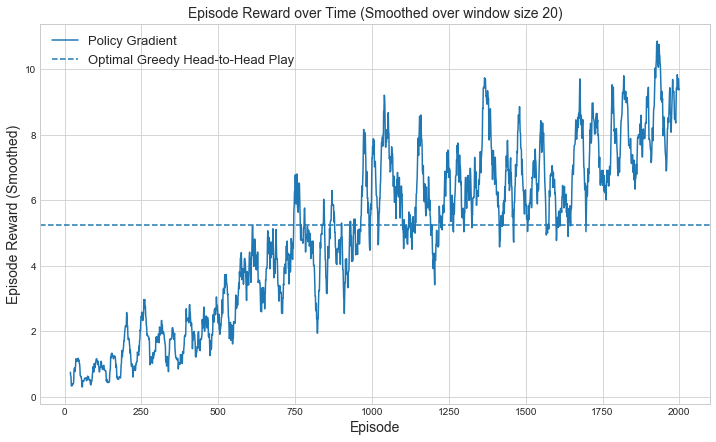

In [77]:
import pandas as pd
plt.style.use("seaborn-whitegrid")
smoothing_window = 20
fig, ax = plt.subplots(figsize=(12,7))
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
plt.plot(rewards_smoothed, label="Policy Gradient")
#plt.axhline(14.33, linestyle="--", label="Optimal Play")
# head-to-head greedy optimal
plt.axhline(5.249, linestyle="--", label="Optimal Greedy Head-to-Head Play")
plt.axhline(6.042, linestyle="--")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Episode Reward (Smoothed)", fontsize=14)
plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window), fontsize=14)
plt.legend(fontsize=13)

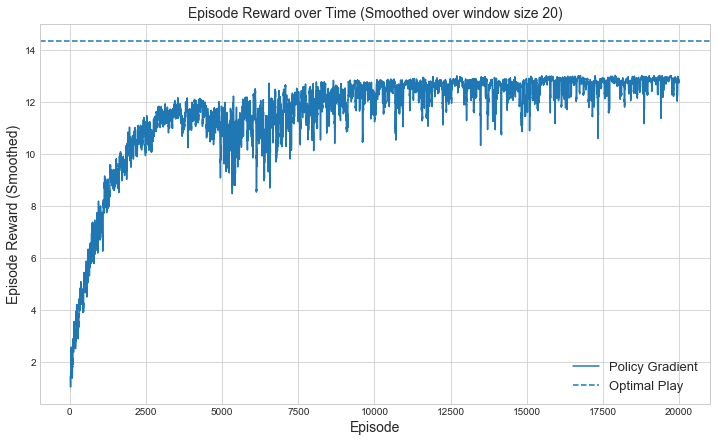

In [46]:
import pandas as pd
plt.style.use("seaborn-whitegrid")
smoothing_window = 20
fig, ax = plt.subplots(figsize=(12,7))
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
plt.plot(rewards_smoothed, label="Policy Gradient")
plt.axhline(14.33, linestyle="--", label="Optimal Play")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Episode Reward (Smoothed)", fontsize=14)
plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window), fontsize=14)
plt.legend(fontsize=13)

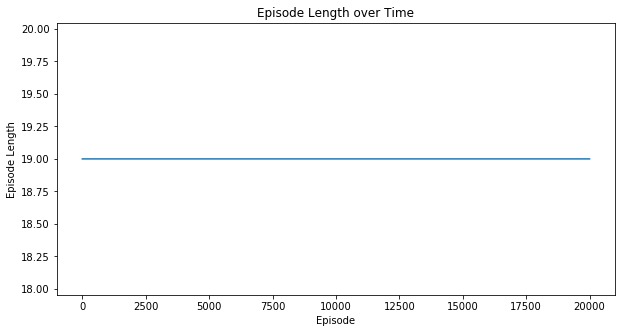

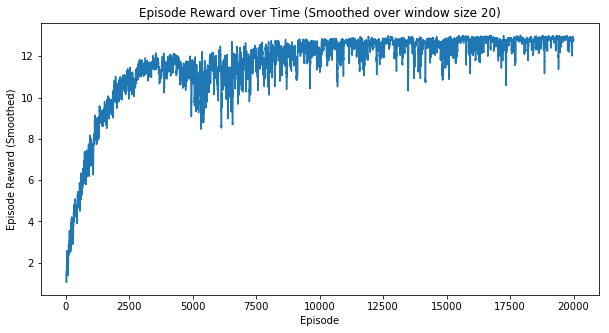

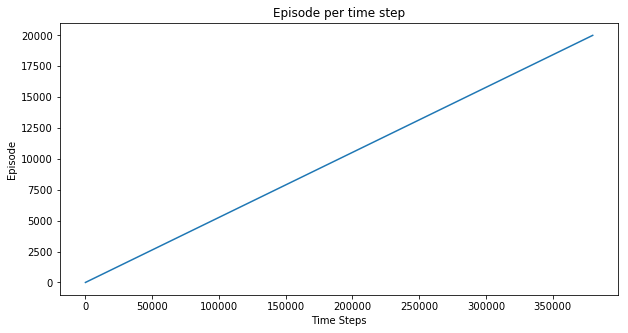

(<matplotlib.figure.Figure at 0x120f697f0>,
 <matplotlib.figure.Figure at 0x1208c3ac8>)

In [22]:
plotting.plot_episode_stats(stats, smoothing_window=20)

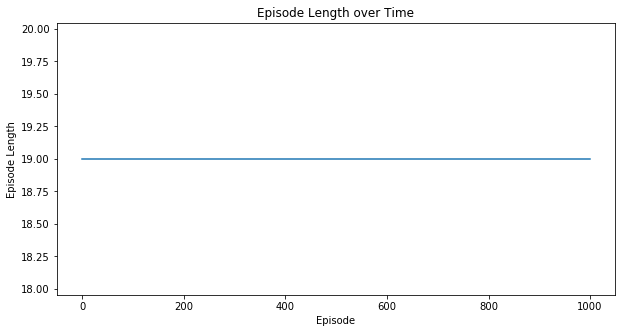

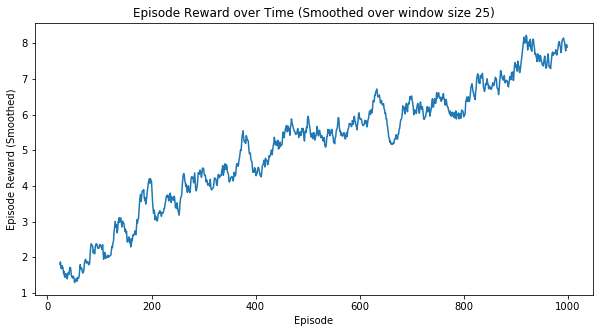

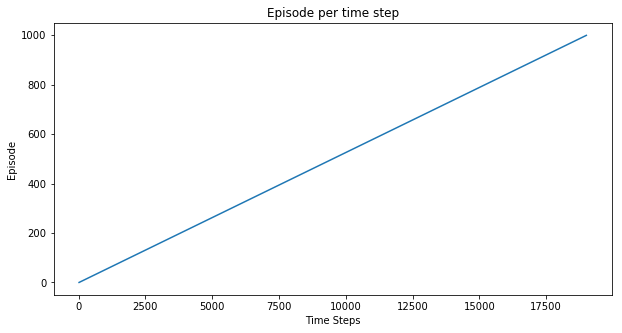

(<matplotlib.figure.Figure at 0x1212db1d0>,
 <matplotlib.figure.Figure at 0x120cc07b8>)

In [14]:
plotting.plot_episode_stats(stats, smoothing_window=25)

In [51]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    stats = reinforce(env, policy_estimator,
                      value_estimator, 10000, discount_factor=.99)

Step 19 @ Episode 10000/10000 (6.0))

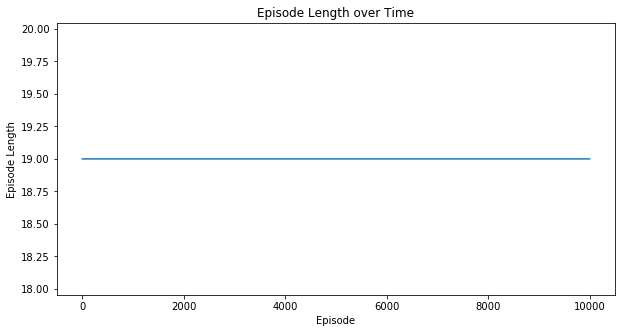

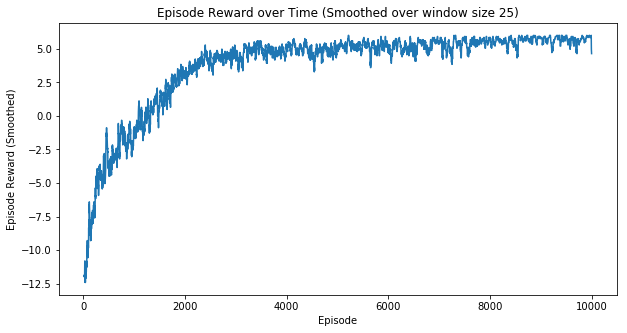

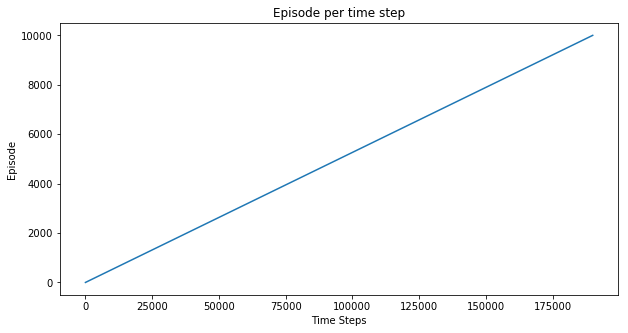

(<matplotlib.figure.Figure at 0x123056908>,
 <matplotlib.figure.Figure at 0x120ce34e0>)

In [54]:
plotting.plot_episode_stats(stats, smoothing_window=25)

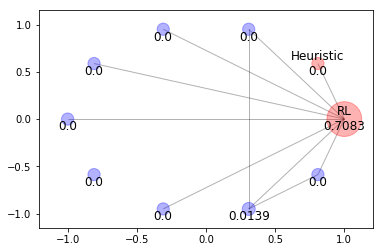

In [55]:
env.render()

In [88]:
saver = tf.train.Saver()

def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        if i_episode % 100 == 0:
            env.render()
        # Reset the environment and pick the first action
        state = env.reset()
        
        episode = []
    
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [89]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

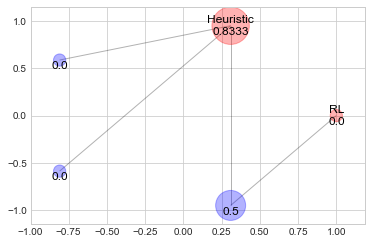

Step 19 @ Episode 100/2000 (0.0)33333333333333)

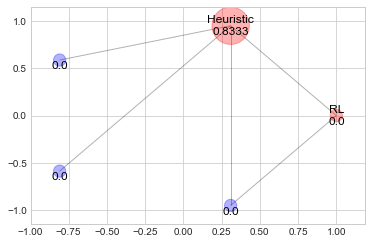

Step 19 @ Episode 200/2000 (0.08333333333333333)

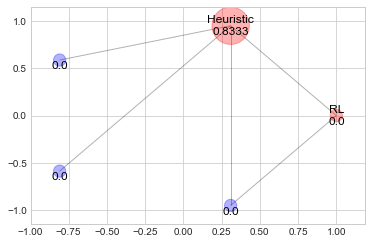

Step 19 @ Episode 300/2000 (0.5833333333333334))

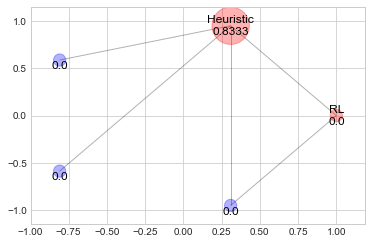

Step 19 @ Episode 400/2000 (0.8333333333333334))

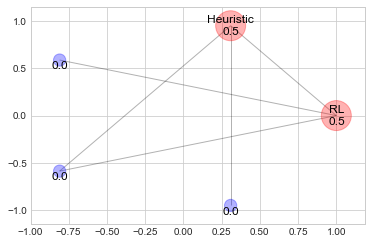

Step 19 @ Episode 500/2000 (2.999999999999999)))

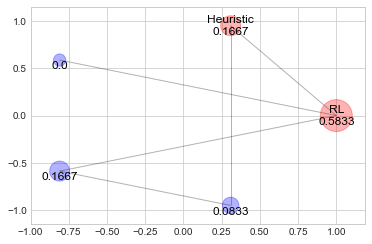

Step 19 @ Episode 600/2000 (5.666666666666668)))

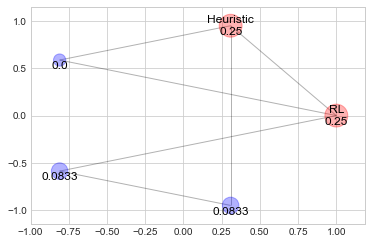

Step 19 @ Episode 700/2000 (1.5)33333333333333))

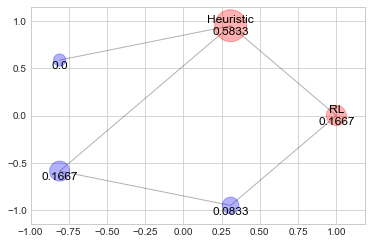

Step 19 @ Episode 800/2000 (2.333333333333333)))

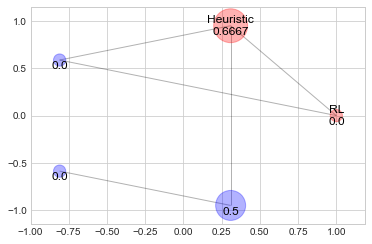

Step 19 @ Episode 900/2000 (0.8333333333333333))

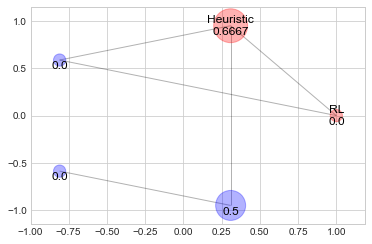

Step 19 @ Episode 1000/2000 (9.666666666666666))

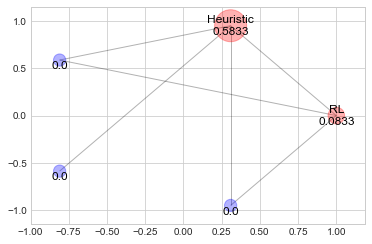

Step 19 @ Episode 1100/2000 (9.416666666666666)))

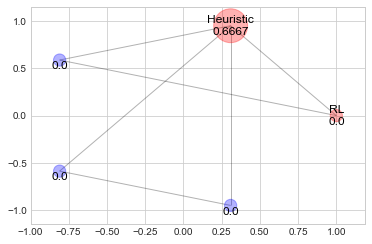

Step 19 @ Episode 1200/2000 (0.0)3333333333333))

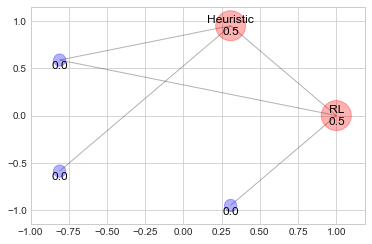

Step 19 @ Episode 1300/2000 (11.333333333333334)

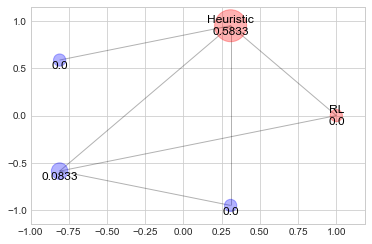

Step 19 @ Episode 1400/2000 (4.249999999999999))

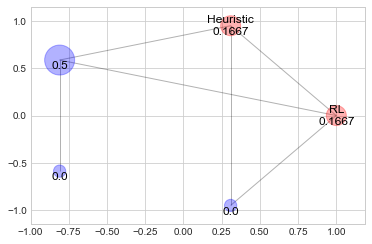

Step 19 @ Episode 1500/2000 (3.7499999999999996)

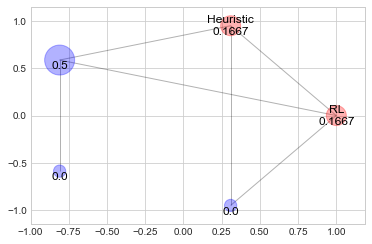

Step 19 @ Episode 1600/2000 (15.833333333333337)

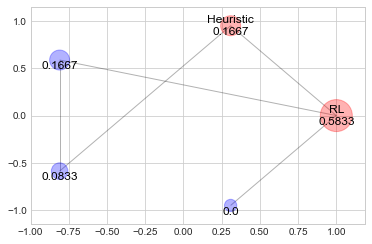

Step 19 @ Episode 1700/2000 (9.5))666666666664))

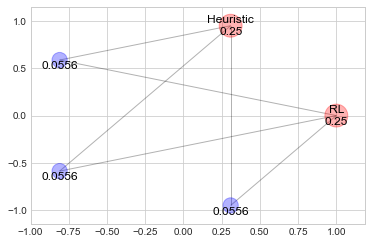

Step 19 @ Episode 1800/2000 (10.166666666666666)

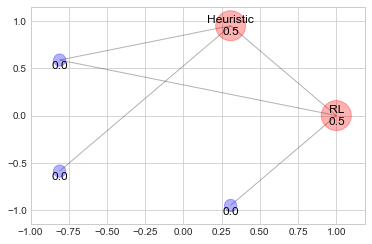

Step 19 @ Episode 1900/2000 (3.666666666666666))

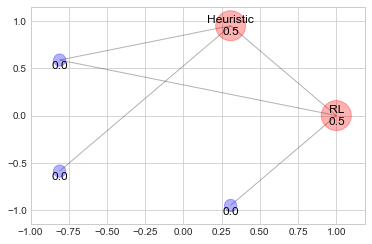

Step 19 @ Episode 2000/2000 (10.0)9999999999996)

In [90]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~300 seemed to work well for me.
    stats = actor_critic(env, policy_estimator, value_estimator, 2000, discount_factor=.99)

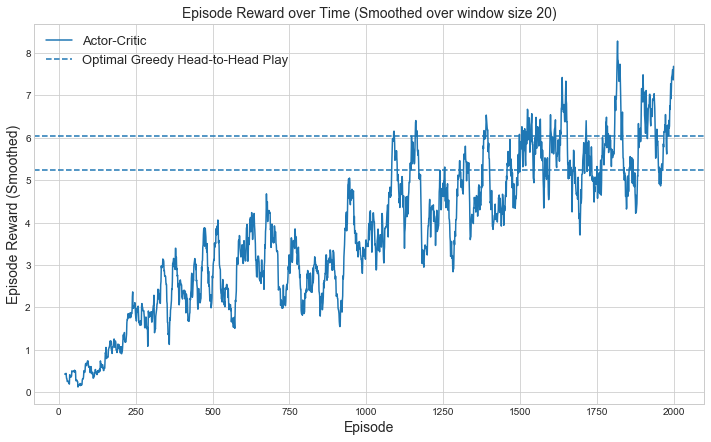

In [92]:
import pandas as pd
plt.style.use("seaborn-whitegrid")
smoothing_window = 20
fig, ax = plt.subplots(figsize=(12,7))
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
plt.plot(rewards_smoothed, label="Actor-Critic")
#plt.axhline(14.33, linestyle="--", label="Optimal Play")
# head-to-head greedy optimal
plt.axhline(5.249, linestyle="--", label="Optimal Greedy Head-to-Head Play")
plt.axhline(6.042, linestyle="--")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Episode Reward (Smoothed)", fontsize=14)
plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window), fontsize=14)
plt.legend(fontsize=13)

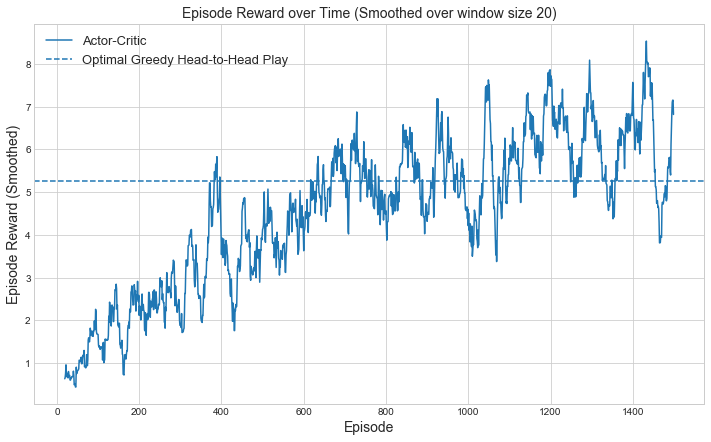

In [74]:
import pandas as pd
plt.style.use("seaborn-whitegrid")
smoothing_window = 20
fig, ax = plt.subplots(figsize=(12,7))
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
plt.plot(rewards_smoothed, label="Actor-Critic")
#plt.axhline(14.33, linestyle="--", label="Optimal Play")
# head-to-head greedy optimal
plt.axhline(5.249, linestyle="--", label="Optimal Greedy Head-to-Head Play")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Episode Reward (Smoothed)", fontsize=14)
plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window), fontsize=14)
plt.legend(fontsize=13)

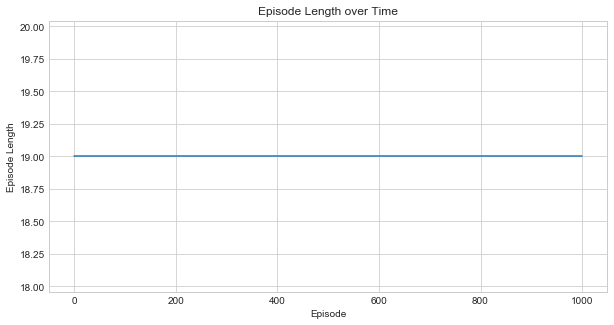

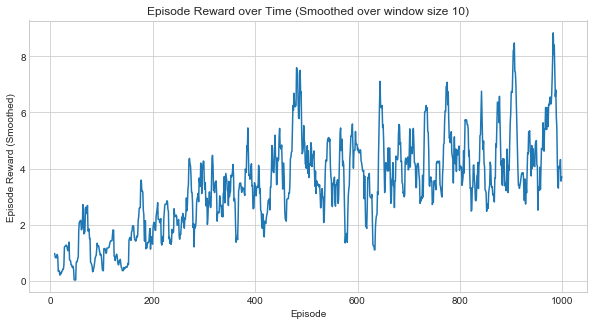

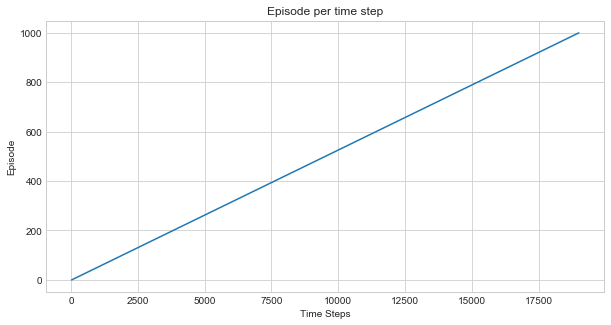

(<matplotlib.figure.Figure at 0x12addb278>,
 <matplotlib.figure.Figure at 0x12a556160>)

In [68]:
plotting.plot_episode_stats(stats, smoothing_window=10)